# PREPROCESSING

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

## 1. Data Preparation

In [3]:
file = 'data/wdbc.data'

df = pd.read_csv(file, header = None)
cols = ["id","diagnosis"] + [
    f"{feat}_{stat}"
    for stat in ["mean","se","worst"]
    for feat in ["radius","texture","perimeter","area",
                 "smoothness","compactness","concavity",
                 "concave_points","symmetry","fractal_dimension"]
]
df.columns = cols
df["diagnosis"] = df["diagnosis"].map({"B": 0.0, "M": 1.0})

I am going to take all those variables that have a correlation higher than 0.3.

| Feature                  | Correlation |
|--------------------------|-------------|
| concave_points_worst     | 0.793566    |
| perimeter_worst          | 0.782914    |
| concave_points_mean      | 0.776614    |
| radius_worst             | 0.776454    |
| perimeter_mean           | 0.742636    |
| area_worst               | 0.733825    |
| radius_mean              | 0.730029    |
| area_mean                | 0.708984    |
| concavity_mean           | 0.696360    |
| concavity_worst          | 0.659610    |
| compactness_mean         | 0.596534    |
| compactness_worst        | 0.590998    |
| radius_se                | 0.567134    |
| perimeter_se             | 0.556141    |
| area_se                  | 0.548236    |
| texture_worst            | 0.456903    |
| smoothness_worst         | 0.421465    |
| symmetry_worst           | 0.416294    |
| texture_mean             | 0.415185    |
| concave_points_se        | 0.408042    |
| smoothness_mean          | 0.358560    |
| symmetry_mean            | 0.330499    |
| fractal_dimension_worst  | 0.323872    |


In [10]:
from scipy.stats import pointbiserialr

correlated_columns = ["diagnosis"]

for col in df.drop(columns=["diagnosis","id"]).columns:
    r, p = pointbiserialr(df["diagnosis"], df[col].astype(float))
    if r>0.3:
        correlated_columns.append(col)


df = df[correlated_columns]


## 2. Outliers

In [11]:
outlier_counts = {}

for col in df.drop(columns=["diagnosis"]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_counts[col] = len(outliers)

pd.Series(outlier_counts).sort_values(ascending=False)


area_se                    65
perimeter_se               38
radius_se                  38
area_worst                 35
area_mean                  25
fractal_dimension_worst    24
symmetry_worst             23
concave_points_se          19
concavity_mean             18
radius_worst               17
compactness_worst          16
compactness_mean           16
perimeter_worst            15
symmetry_mean              15
radius_mean                14
perimeter_mean             13
concavity_worst            12
concave_points_mean        10
texture_mean                7
smoothness_worst            7
smoothness_mean             6
texture_worst               5
concave_points_worst        0
dtype: int64

In [6]:
def get_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] < lower) | (df[col] > upper)]

In [19]:
def get_outlier_categories(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    lower_outliers = df[df[col] < lower]
    upper_outliers = df[df[col] > upper]

    return lower_outliers, upper_outliers


In [18]:
outlier_summary = []

for col in df.drop(columns=["diagnosis"]).columns:
    lower, upper = get_outlier_categories(df, col)
    outlier_summary.append([
        col,
        len(lower),
        len(upper),
        lower["diagnosis"].sum(),     # malignant lower
        upper["diagnosis"].sum()      # malignant upper
    ])

outlier_df = pd.DataFrame(outlier_summary, 
                          columns=["Feature", "Lower Outliers", "Upper Outliers",
                                   "Lower Malignant", "Upper Malignant"])
outlier_df


,Feature,Lower Outliers,Upper Outliers,Lower Malignant,Upper Malignant
0,radius_mean,0,14,0.0,14.0
1,texture_mean,0,7,0.0,5.0
2,perimeter_mean,0,13,0.0,13.0
3,area_mean,0,25,0.0,25.0
4,smoothness_mean,1,5,0.0,3.0
5,compactness_mean,0,16,0.0,16.0
6,concavity_mean,0,18,0.0,15.0
7,concave_points_mean,0,10,0.0,10.0
8,symmetry_mean,1,14,0.0,9.0
9,radius_se,0,38,0.0,37.0


After this analysis, we can see that most of upper outliers are related to a malign tumor. That make sense, as a zone where there is a tumor normaly is bigger than other sites. Outliers in this dataset reflect meaningful biological variability related to malignant cell growth. Therefore, they are not noise and should not be removed during preprocessing.

If you dropped high outliers:

- Benign and malignant distributions would overlap more.

- The model would confuse them more.

- Accuracy would drop.

- Sensitivity (detecting malignant) would decrease.

## 3. Data Consistency

Tranforming target from float to category

In [20]:
df["diagnosis"] = df["diagnosis"].map({0.0: "Benign", 1.0: "Malignant"}).astype("category")

## 4. Data Transformation

Scale BEFORE splitting is the wrong approach.

Why?

- You leak information from the test set into the scaler.

- This causes overly optimistic performance (data leakage).

- The model learns distribution of values it should never see.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Split features and target
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

# 1) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3) Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)


## 5. Data Reduction

We are going to use Principal Component Analysis (PCA) to remove unnecessary or repetitive information, making the data easier to analyse and saving storage space.

Questions:

1. PCA should be applied before or after train–test split?

2. PCA should be applied on scaled or unscaled data?

1. Apply PCA ONLY on the TRAINING SET

Just like scaling, PCA must be learned only from training data.

Why?

- PCA learns linear combinations from covariance matrix

- That covariance depends on the distribution of the data

- So using test data leaks information

PCA should be fitted on train, and applied to test

2. PCA must be applied on scaled data

Why?

- PCA is sensitive to magnitude of features

- Without scaling:

    - Features with large units dominate

    - PCA structure is distorted

Always scale BEFORE PCA.

In [24]:
from sklearn.decomposition import PCA

# 1) Fit PCA only on training data
pca = PCA()
pca.fit(X_train_scaled)

# 2) Transform both sets
X_train_pca = pca.transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3) Variance explained
expl_var = np.cumsum(pca.explained_variance_ratio_)
expl_var[:10]  # first 10 components

array([0.54794962, 0.72007671, 0.79977344, 0.85180817, 0.894493  ,
       0.92965136, 0.95365311, 0.96540951, 0.9733034 , 0.97981549])

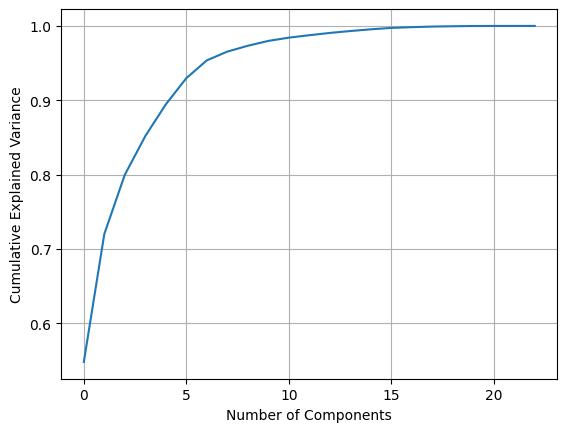

In [25]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

<Axes: >

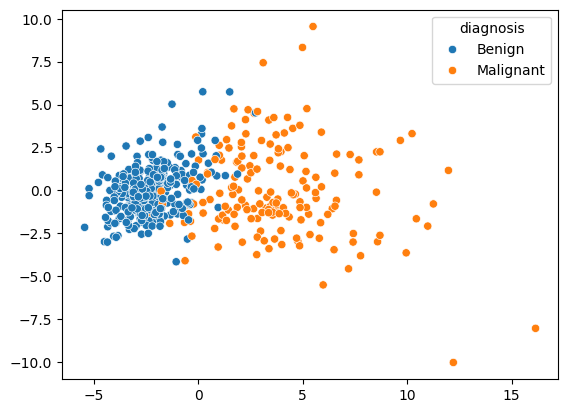

In [34]:
import seaborn as sns
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train)


A scatter plot of PC1 vs. PC2 colored by diagnosis reveals a clear class separation: benign tumors cluster tightly on the left, while malignant tumors occupy more dispersed regions toward higher PC1 and PC2 values. This indicates that PCA has successfully captured meaningful biological variability in the reduced space, supporting the feasibility of classification models based on principal components

In [28]:
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns
)
loadings


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
radius_mean,0.240566,-0.218994,0.037905,-0.208430,-0.016230,0.044468,0.128507,-0.081941,-0.091059,-0.041567,...,0.124815,0.215905,-0.228013,0.006838,-0.182416,-0.118438,0.053810,-0.218877,-0.207018,0.703960
texture_mean,0.108314,-0.046228,0.582567,0.385232,-0.021510,-0.048185,0.125898,-0.126876,-0.040432,-0.084898,...,0.181950,-0.526089,0.025224,-0.059176,0.046684,-0.041980,-0.000325,-0.005330,0.004522,0.000918
perimeter_mean,0.248009,-0.197675,0.029769,-0.191547,-0.002744,0.041299,0.121055,-0.116104,-0.076241,-0.066780,...,0.092152,0.219656,-0.193097,-0.061376,-0.133125,-0.122780,0.070519,-0.095976,-0.384564,-0.688329
area_mean,0.241980,-0.229793,0.007473,-0.155016,-0.044711,0.018178,0.050534,-0.082352,-0.026346,0.074665,...,0.138549,0.238710,0.042327,0.021810,0.213251,0.495270,-0.306192,0.300113,0.423992,-0.034361
smoothness_mean,0.145382,0.270648,-0.232460,0.079119,-0.363026,-0.388895,0.262829,-0.184647,-0.004865,-0.227028,...,0.084801,0.000298,0.077935,0.014804,0.052349,-0.033971,-0.080884,0.004006,0.002542,-0.007518
compactness_mean,0.237203,0.209187,-0.066734,0.042928,0.144414,-0.034230,0.012970,-0.377123,-0.130453,-0.379802,...,-0.353087,0.027259,0.224625,-0.360303,-0.337668,0.222548,0.054677,0.021682,0.047655,0.046675
concavity_mean,0.256760,0.096797,-0.055829,0.036886,0.215482,-0.016422,0.059078,-0.220654,0.494179,0.147845,...,-0.238751,-0.011841,0.028869,0.144219,0.065294,-0.392982,-0.456665,-0.054113,-0.008683,0.009984
concave_points_mean,0.270733,0.012525,-0.068571,-0.051316,0.014404,-0.035217,0.196388,-0.184594,0.103098,-0.065273,...,0.163248,-0.123190,-0.075895,0.315797,0.263457,0.150772,0.563045,-0.008805,0.021346,0.007713
symmetry_mean,0.133542,0.262273,-0.151987,0.249718,-0.244266,0.533042,0.213608,-0.302720,-0.145538,0.486873,...,0.091684,0.032333,-0.031337,-0.013265,-0.002125,-0.012792,-0.005891,-0.002630,0.007290,-0.000191
radius_se,0.214323,-0.176931,-0.202292,0.366961,-0.087148,-0.027175,-0.247959,0.099421,0.008618,-0.035072,...,-0.062157,-0.182218,-0.336101,0.390071,-0.473048,0.240204,-0.146245,0.193713,-0.113884,-0.011478


In [29]:
top_vars = {}

for pc in loadings.columns:
    # Sort by absolute loading values
    top = loadings[pc].abs().sort_values(ascending=False).head(3)
    top_vars[pc] = list(top.index)

pd.DataFrame(top_vars)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23
0,concave_points_mean,fractal_dimension_worst,texture_worst,texture_mean,concave_points_se,symmetry_worst,concave_points_se,concave_points_se,concavity_worst,symmetry_mean,...,concave_points_worst,texture_worst,area_se,compactness_worst,perimeter_se,area_mean,concave_points_mean,perimeter_worst,radius_worst,radius_mean
1,concave_points_worst,smoothness_worst,texture_mean,perimeter_se,smoothness_worst,symmetry_mean,fractal_dimension_worst,compactness_mean,concavity_mean,symmetry_worst,...,compactness_mean,texture_mean,area_worst,radius_se,radius_se,concavity_mean,concavity_mean,radius_worst,area_worst,perimeter_mean
2,perimeter_worst,symmetry_worst,smoothness_mean,radius_se,smoothness_mean,smoothness_worst,area_se,symmetry_worst,fractal_dimension_worst,compactness_mean,...,area_se,area_worst,perimeter_se,perimeter_se,compactness_mean,perimeter_worst,concave_points_worst,area_mean,area_mean,radius_worst


**PC1 — “Aggressiveness / Tumor Shape Complexity”**

- concave_points_mean

- concave_points_worst

- perimeter_worst

These relate to how irregular the edges of the tumor are, which is highly associated with malignancy.

Malignant tumors tend to have rougher, more concave borders.

**PC2 — “Boundary Smoothness vs Fractal Pattern”**

- fractal_dimension_worst

- smoothness_worst

- symmetry_worst

These describe local structural irregularities.

Malignant tumors often have less symmetric and more complex boundaries.

**PC3 — “Texture Profile”**

- texture_worst

- texture_mean

- smoothness_mean

Texture reflects variability in pixel intensity within the tumor area.

Greater texture variability can indicate malignant tissue heterogeneity.

Although with two principal components is enough to distinguish 2 clusters, these two only explain 70% of variability. Then, we are going to take 5 principal components to obtain a 90% of explained variance.


# Preprocessing function

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pointbiserialr


def preprocess_data(
    file='data/wdbc.data',
    corr_threshold=0.3,
    test_size=0.2,
    random_state=42
):
    # -------------------------------------
    # 1) Load dataset and rename columns
    # -------------------------------------
    df = pd.read_csv(file, header=None)
    cols = ["id", "diagnosis"] + [
        f"{feat}_{stat}"
        for stat in ["mean", "se", "worst"]
        for feat in ["radius", "texture", "perimeter", "area",
                     "smoothness", "compactness", "concavity",
                     "concave_points", "symmetry", "fractal_dimension"]
    ]
    df.columns = cols

    # -------------------------------------
    # 2) Numerical encoding for correlation filtering
    # -------------------------------------
    df["diagnosis"] = df["diagnosis"].map({"B": 0.0, "M": 1.0})

    correlated_columns = ["diagnosis"]
    for col in df.drop(columns=["diagnosis", "id"]).columns:
        r, _ = pointbiserialr(df["diagnosis"], df[col].astype(float))
        if r > corr_threshold:
            correlated_columns.append(col)

    df = df[correlated_columns]

    # Convert back to category labels
    df["diagnosis"] = df["diagnosis"].map({0.0: "Benign", 1.0: "Malignant"}).astype("category")

    # -------------------------------------
    # 3) Split into X and y
    # -------------------------------------
    X = df.drop(columns=["diagnosis"])
    y = df["diagnosis"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # -------------------------------------
    # 4) Scaling
    # -------------------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # -------------------------------------
    # 5) PCA
    # -------------------------------------
    pca = PCA()
    pca.fit(X_train_scaled)

    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

    # -------------------------------------
    # 6) Return everything useful
    # -------------------------------------
    return {
        "df": df,                            
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "X_train_pca": X_train_pca,
        "X_test_pca": X_test_pca
    }
